## 1. 연구목적
#### - 마키아벨리즘 심리테스트를 활용하여 테스트 참가자의 국가선거 투표여부 예측

## - 데이터 설명 :
https://www.dacon.io/competitions/official/235647/talkboard/401534?page=1&dtype=recent&ptype=pub
### Q□A : 질문에 대한 응답
### Q□E : 질문에 응답하기까지 걸린 시간
### age_group : 연령
#### education : 교육 수준? 1=Less than high school, 2=High school, 3=University degree, 4=Graduate degree, 0=무응답
### engnat : 모국어가 영어? (1=Yes, 2=No, 0=무응답)
### familysize : 형제자매 수
### gender : 성별 (Male, Female)
### hand : 필기하는 손 (1=Right, 2=Left, 3=Both, 0=무응답)
### married : 혼인 상태 (1=Never married, 2=Currently married, 3=Previously married, 0=Other)
### race : 인종 (Asian, Arab, Black, Indigenous Australian, Native American, White, Other)
### religion : 종교 (Agnostic, Atheist, Buddhist, Christian_Catholic, Christian_Mormon, Christian_Protestant, Christian_Other, Hindu, ##Jewish, Muslim, Sikh, Other)
### tp__ : items were rated "I see myself as:" _____ such that
#### - tp01 : Extraverted, enthusiastic.
#### - tp02 : Critical, quarrelsome.
#### - tp03 : Dependable, self-disciplined.
#### - tp04 : Anxious, easily upset.
#### - tp05 : Open to new experiences, complex.
#### - tp06 : Reserved, quiet.
#### - tp07 : Sympathetic, warm.
#### - tp08 : Disorganized, careless.
#### - tp09 : Calm, emotionally stable.
#### - tp10 : Conventional, uncreative.
### urban : 유년기의 거주 구역 (1=Rural (country side), 2=Suburban, 3=Urban (town, city), 0=무응답)
### wr_(01~13) : 실존하는 해당 단어의 정의을 앎 (1=Yes, 0=No)
### wf_(01~03) : 허구인 단어의 정의를 앎 (1=Yes, 0=No)
### voted (타겟): 지난 해 국가 선거 투표 여부 (1=Yes, 2=No) -> (0 = yes, 1 = No)





   






## 마키아벨리즘이란? 
### “ 개인적인 욕구의 충족을 위해 남을 속이거나 조종하려는 욕구를 가리키는 용어” 로 사용됨


## 1. Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from string import ascii_lowercase
from itertools import combinations

import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import  GradientBoostingClassifier
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report

## 2.  데이터 현황 및 분석

In [2]:
def summary(train) :
    tf = pd.DataFrame({'데이터형태(dtypes)' : train.dtypes,
                       '결측치 수(null)' : train.isnull().sum(),
                       '고유값 수(nunique)' : train.nunique()})
    return tf
def summary(test) :
    tf = pd.DataFrame({'데이터형태(dtypes)' : test.dtypes,
                       '결측치 수(null)' : test.isnull().sum(),
                       '고유값 수(nunique)' : test.nunique()})
    return tf
def summary(sub) :
    tf = pd.DataFrame({'데이터형태(dtypes)' : sub.dtypes,
                       '결측치 수(null)' : sub.isnull().sum(),
                       '고유값 수(nunique)' : sub.nunique()})
    return tf

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test_x.csv')
sub = pd.read_csv('sample_submission.csv')

## 3. 데이터 전처리 및 EDA

### 1) 데이터 탐색


In [4]:
train.head()

,index,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
0,0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,...,0,1,0,1,1,0,1,0,1,1
1,1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,...,1,1,0,1,1,0,1,0,1,1
2,2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,...,1,1,0,1,1,1,1,0,1,1
3,3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,...,0,0,0,0,1,0,1,0,1,1
4,4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,...,1,1,1,1,1,0,1,1,1,1


In [5]:
test.head()

,index,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
0,0,3.0,736,2.0,2941,3.0,4621,1.0,4857,2.0,...,0,1,0,0,1,0,1,0,1,1
1,1,3.0,514,2.0,1952,3.0,1552,3.0,821,4.0,...,0,0,0,0,0,0,0,0,0,0
2,2,3.0,500,2.0,2507,4.0,480,2.0,614,2.0,...,0,1,0,1,1,0,1,0,1,1
3,3,1.0,669,1.0,1050,5.0,1435,2.0,2252,5.0,...,1,1,1,1,1,1,1,1,1,1
4,4,2.0,499,1.0,1243,5.0,845,2.0,1666,2.0,...,1,1,0,1,1,0,1,1,1,1


### 2) Null값 & 자료형 확인


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45532 entries, 0 to 45531
Data columns (total 78 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       45532 non-null  int64  
 1   QaA         45532 non-null  float64
 2   QaE         45532 non-null  int64  
 3   QbA         45532 non-null  float64
 4   QbE         45532 non-null  int64  
 5   QcA         45532 non-null  float64
 6   QcE         45532 non-null  int64  
 7   QdA         45532 non-null  float64
 8   QdE         45532 non-null  int64  
 9   QeA         45532 non-null  float64
 10  QeE         45532 non-null  int64  
 11  QfA         45532 non-null  float64
 12  QfE         45532 non-null  int64  
 13  QgA         45532 non-null  float64
 14  QgE         45532 non-null  int64  
 15  QhA         45532 non-null  float64
 16  QhE         45532 non-null  int64  
 17  QiA         45532 non-null  float64
 18  QiE         45532 non-null  int64  
 19  QjA         45532 non-nul

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11383 entries, 0 to 11382
Data columns (total 77 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       11383 non-null  int64  
 1   QaA         11383 non-null  float64
 2   QaE         11383 non-null  int64  
 3   QbA         11383 non-null  float64
 4   QbE         11383 non-null  int64  
 5   QcA         11383 non-null  float64
 6   QcE         11383 non-null  int64  
 7   QdA         11383 non-null  float64
 8   QdE         11383 non-null  int64  
 9   QeA         11383 non-null  float64
 10  QeE         11383 non-null  int64  
 11  QfA         11383 non-null  float64
 12  QfE         11383 non-null  int64  
 13  QgA         11383 non-null  float64
 14  QgE         11383 non-null  int64  
 15  QhA         11383 non-null  float64
 16  QhE         11383 non-null  int64  
 17  QiA         11383 non-null  float64
 18  QiE         11383 non-null  int64  
 19  QjA         11383 non-nul

###  3) 마키아벨리즘 테스트 QA & QE 상관관계 분석

### Q□A : 질문에 대한 응답
### Q□E : 질문에 응답하기까지 걸린 시간

In [8]:
eda_train = train.copy()

In [9]:
Answers = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA',
             'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
             'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 
             'QpA', 'QqA', 'QrA', 'QsA', 'QtA']

### 부호가 같은 문항끼리는 (QbA와QcA) 상관관계 값이 양수,
### 부호가 다른 문항끼리는 (QbA와QeA) 상관관계 값이 음수

<AxesSubplot:>

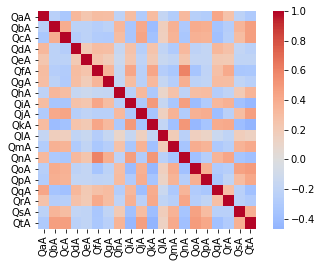

In [10]:
correlations = eda_train[Answers].corr(method = 'spearman')
sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)

In [11]:
for col in eda_train[Answers]:
    print(sorted(eda_train[col].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]


In [12]:
flipping_columns = ["QeA", "QfA", "QkA", "QqA", "QrA"]
for flip in flipping_columns: 
    eda_train[flip] = 6 - eda_train[flip]

### 이미 알고있는 (-) 부호 문항을(+)로 reverse 
### QaA, QdA, QgA, QiA,QnA는(-)부호

<AxesSubplot:>

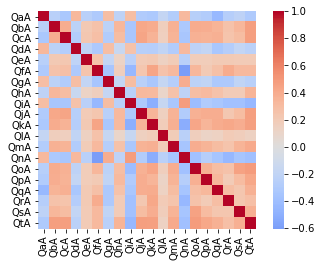

In [13]:
correlations = eda_train[Answers].corr(method = 'spearman')
sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)

In [14]:
flipping_columns = ["QaA", "QdA", "QgA", "QiA", "QnA"]
for flip in flipping_columns: 
    eda_train[flip] = 6 - eda_train[flip]

### (-) 부호인 secret 문항을(+)로 변환

<AxesSubplot:>

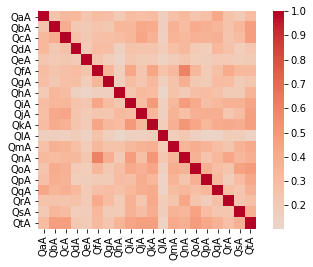

In [15]:
correlations = eda_train[Answers].corr(method = 'spearman')
sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)

##  4. Feature Engineering

In [16]:
x_train = train.copy()
x_train.drop('voted', axis=1, inplace = True)
y_train = train['voted']

In [17]:
dataset = [x_train, test]

### 1) 마키아밸리 테스트 FE

### 파생변수 Mach score 생성

In [18]:
questions = [i for i in list(ascii_lowercase)[:20]]
answers = [('Q'+i+'A') for i in questions]
for data in dataset:
  data['Mach_score'] = data[answers].mean(axis = 1)
  data['Mach_score'] = data['Mach_score']*20 # 마하 스코어 최대치 5 -> 100 

### EDA에서 결과에 큰 영향이 없다고 판단된 feature들을 제거

In [19]:
x_train.drop(['index','QaE', 'QbE', 'QcE', 'QdE', 'QeE', 'QfE', 'QgE', 'QhE', 'QiE', 'QjE', 
              'QkE', 'QlE', 'QmE', 'QnE', 'QoE', 'QpE', 'QqE', 'QrE', 'QsE', 'QtE', 
              'QaA', 'QbA', 'QcA', 'QdA', 'QeA', 'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
              'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 'QpA', 'QqA', 'QrA', 'QsA', 'QtA'], inplace = True, axis = 1)

In [20]:
test.drop(['index','QaE', 'QbE', 'QcE', 'QdE', 'QeE', 'QfE', 'QgE', 'QhE', 'QiE', 'QjE', 
              'QkE', 'QlE', 'QmE', 'QnE', 'QoE', 'QpE', 'QqE', 'QrE', 'QsE', 'QtE', 
              'QaA', 'QbA', 'QcA', 'QdA', 'QeA', 'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
              'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 'QpA', 'QqA', 'QrA', 'QsA', 'QtA'], inplace = True, axis = 1)

In [21]:
for data in dataset:
  data.drop('hand', axis=1, inplace = True)

In [22]:
wr_list = [('wr_0'+str(i)) for i in range(1,10)]
wr_list.extend([('wr_'+str(i)) for i in range(10,14)])
wr_no_need = [i for i in wr_list if i not in ['wr_01', 'wr_03', 'wr_06', 'wr_09', 'wr_11']]

In [23]:
for data in dataset:
  data.drop(wr_no_need, axis=1, inplace = True)

### 2) 특성공학

### 10개의 질문에 따른 5개의 파생변수 생성

In [24]:
for data in dataset:
    data['외향성'] = (data['tp01']+data['tp06'])/2
    data['친화성'] = (data['tp07']+data['tp02'])/2
    data['성실성'] = (data['tp03']+data['tp08'])/2
    data['정서적 안정성'] = (data['tp09']+data['tp04'])/2
    data['경험개방성'] = (data['tp05']+data['tp10'])/2

### 파생변수 생성 후 기존 tp변수 drop

In [25]:
x_train.drop(['tp01','tp02','tp03','tp04','tp05','tp06','tp07','tp08','tp09','tp10'], inplace = True, axis = 1)
test.drop(['tp01','tp02','tp03','tp04','tp05','tp06','tp07','tp08','tp09','tp10'], inplace = True, axis = 1)

### LabelEncoder로 Object -> int Labeling

In [26]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
needenco = ['age_group', 'gender', 'race', 'religion']
for i in needenco:
  x_train[i] = encoder.fit_transform(x_train[i])
  test[i] = encoder.transform(test[i])

### Auto ML용 데이터 df 생성 ( x_train + voted )

In [27]:
df = pd.concat([x_train, y_train], axis =1,  sort = False) # Auto ML용

In [28]:
df

,age_group,education,engnat,familysize,gender,married,race,religion,urban,wf_01,...,wr_06,wr_09,wr_11,Mach_score,외향성,친화성,성실성,정서적 안정성,경험개방성,voted
0,3,2,1,4,0,3,6,10,1,0,...,0,0,0,61.0,1.5,4.5,3.0,2.5,2.5,2
1,2,4,2,3,0,1,1,7,3,0,...,0,0,0,64.0,1.5,2.0,2.0,0.0,2.5,2
2,3,3,1,3,1,2,6,10,2,0,...,0,1,0,56.0,3.0,2.5,3.5,3.0,3.0,1
3,2,4,2,0,0,1,1,7,3,0,...,0,0,0,71.0,2.5,2.5,2.0,1.0,2.0,1
4,2,3,1,2,1,2,6,0,1,0,...,1,0,1,58.0,1.5,0.5,3.5,4.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,1,2,1,1,0,1,6,8,3,0,...,0,1,0,53.0,3.5,2.5,3.0,3.5,3.0,2
45528,3,2,1,2,1,1,6,1,1,0,...,0,1,0,58.0,2.5,2.5,3.0,2.0,3.0,2
45529,1,2,1,1,0,1,6,5,2,0,...,0,0,0,62.0,2.5,2.0,2.0,2.5,3.0,1
45530,4,4,1,2,1,1,6,1,0,0,...,0,1,0,52.0,1.0,2.5,1.0,3.0,2.0,1


### 3) 특성선택

In [29]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [30]:
def logistic_regression(x_train , y_train):
    embeded_lr2_selector = SelectFromModel(LogisticRegression(),# Logistic Regression 모델을 통해 특성 선택
                                           threshold='median') 
    X_norm = MinMaxScaler().fit_transform(x_train)
    embeded_lr2_selector.fit(X_norm, y_train)
    embeded_lr2_support = embeded_lr2_selector.get_support()
    embeded_lr2_feature = x_train.loc[:,embeded_lr2_support].columns.tolist()
    
    return embeded_lr2_support, embeded_lr2_feature

embeded_lr2_support, embeded_lr2_feature = logistic_regression(x_train , y_train)
'/'.join(embeded_lr2_feature)
#len(embeded_lr2_feature)

'age_group/education/race/urban/wr_01/wr_03/wr_06/외향성/친화성/성실성/정서적 안정성/경험개방성'

In [31]:
from sklearn.ensemble import RandomForestClassifier
def random_forest(x_train , y_train):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(), # RandomForestClassifier 을 통해 특성 선택 
                                          threshold='median')
    embeded_rf_selector.fit(x_train , y_train)    
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = x_train.loc[:,embeded_rf_support].columns.tolist()
    return embeded_rf_support, embeded_rf_feature

embeded_rf_support, embeded_rf_feature = random_forest(x_train , y_train)
'/'.join(embeded_rf_feature)

'age_group/education/familysize/married/race/religion/Mach_score/외향성/친화성/성실성/정서적 안정성/경험개방성'

In [32]:
forest = RandomForestClassifier()
forest.fit(x_train , y_train)

RandomForestClassifier()

### 4) 특성변수 중요도
#### - 랜덤포레스트 모델의 입력변수의 중요도

<BarContainer object of 23 artists>

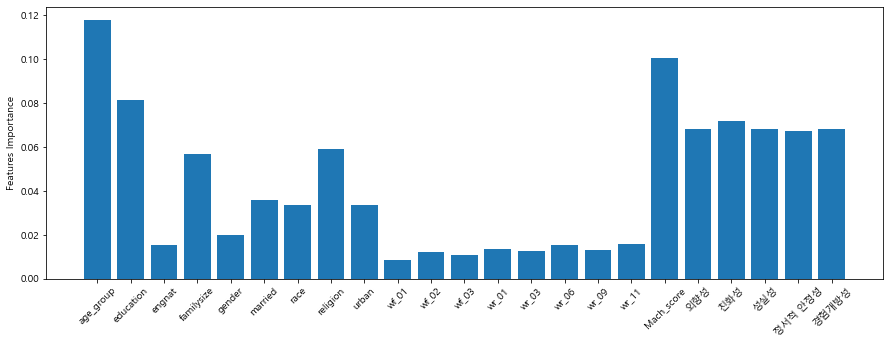

In [34]:
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline
plt.figure(figsize=(15,5)); plt.ylabel('Features Importance')
plt.xticks(np.arange(x_train.shape[1]), x_train.columns, rotation='45')
plt.bar(range(x_train.shape[1]), forest.feature_importances_)

### 5) 특성변수 permutation-based 중요도
#### - 특정 변수의 값을 무작위로 재정렬하여(permutation) 학습하는 경우 모델의 정확도에 영향을 얼마나 주는지를 가리키는 지표
#### - 예측에 영향을 미치는 입력변수의 중요도가 높은 순서대로 확인

<AxesSubplot:xlabel='0'>

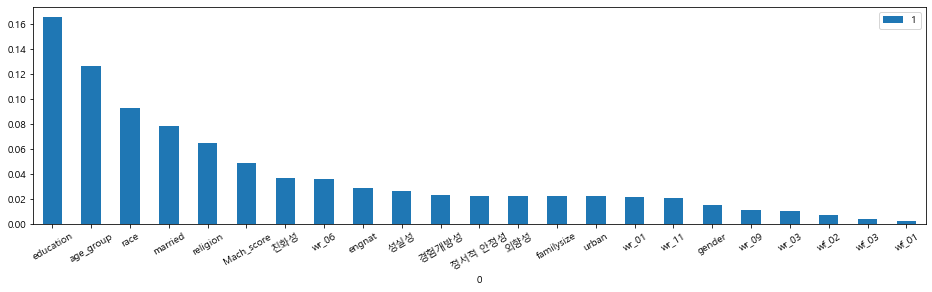

In [35]:
from sklearn.inspection import permutation_importance
results123 = permutation_importance(forest, x_train, y_train, n_repeats=10, random_state=0)

data123 = pd.DataFrame(list(zip(x_train.columns, results123.importances_mean)))
data123.sort_values(by =1, ascending= False, inplace =True)
data123.plot(kind='bar', x=0, y=1, rot='30', figsize=(16, 4))

### 6) 특성변수 영향도
#### - 개별 변수의 민감도

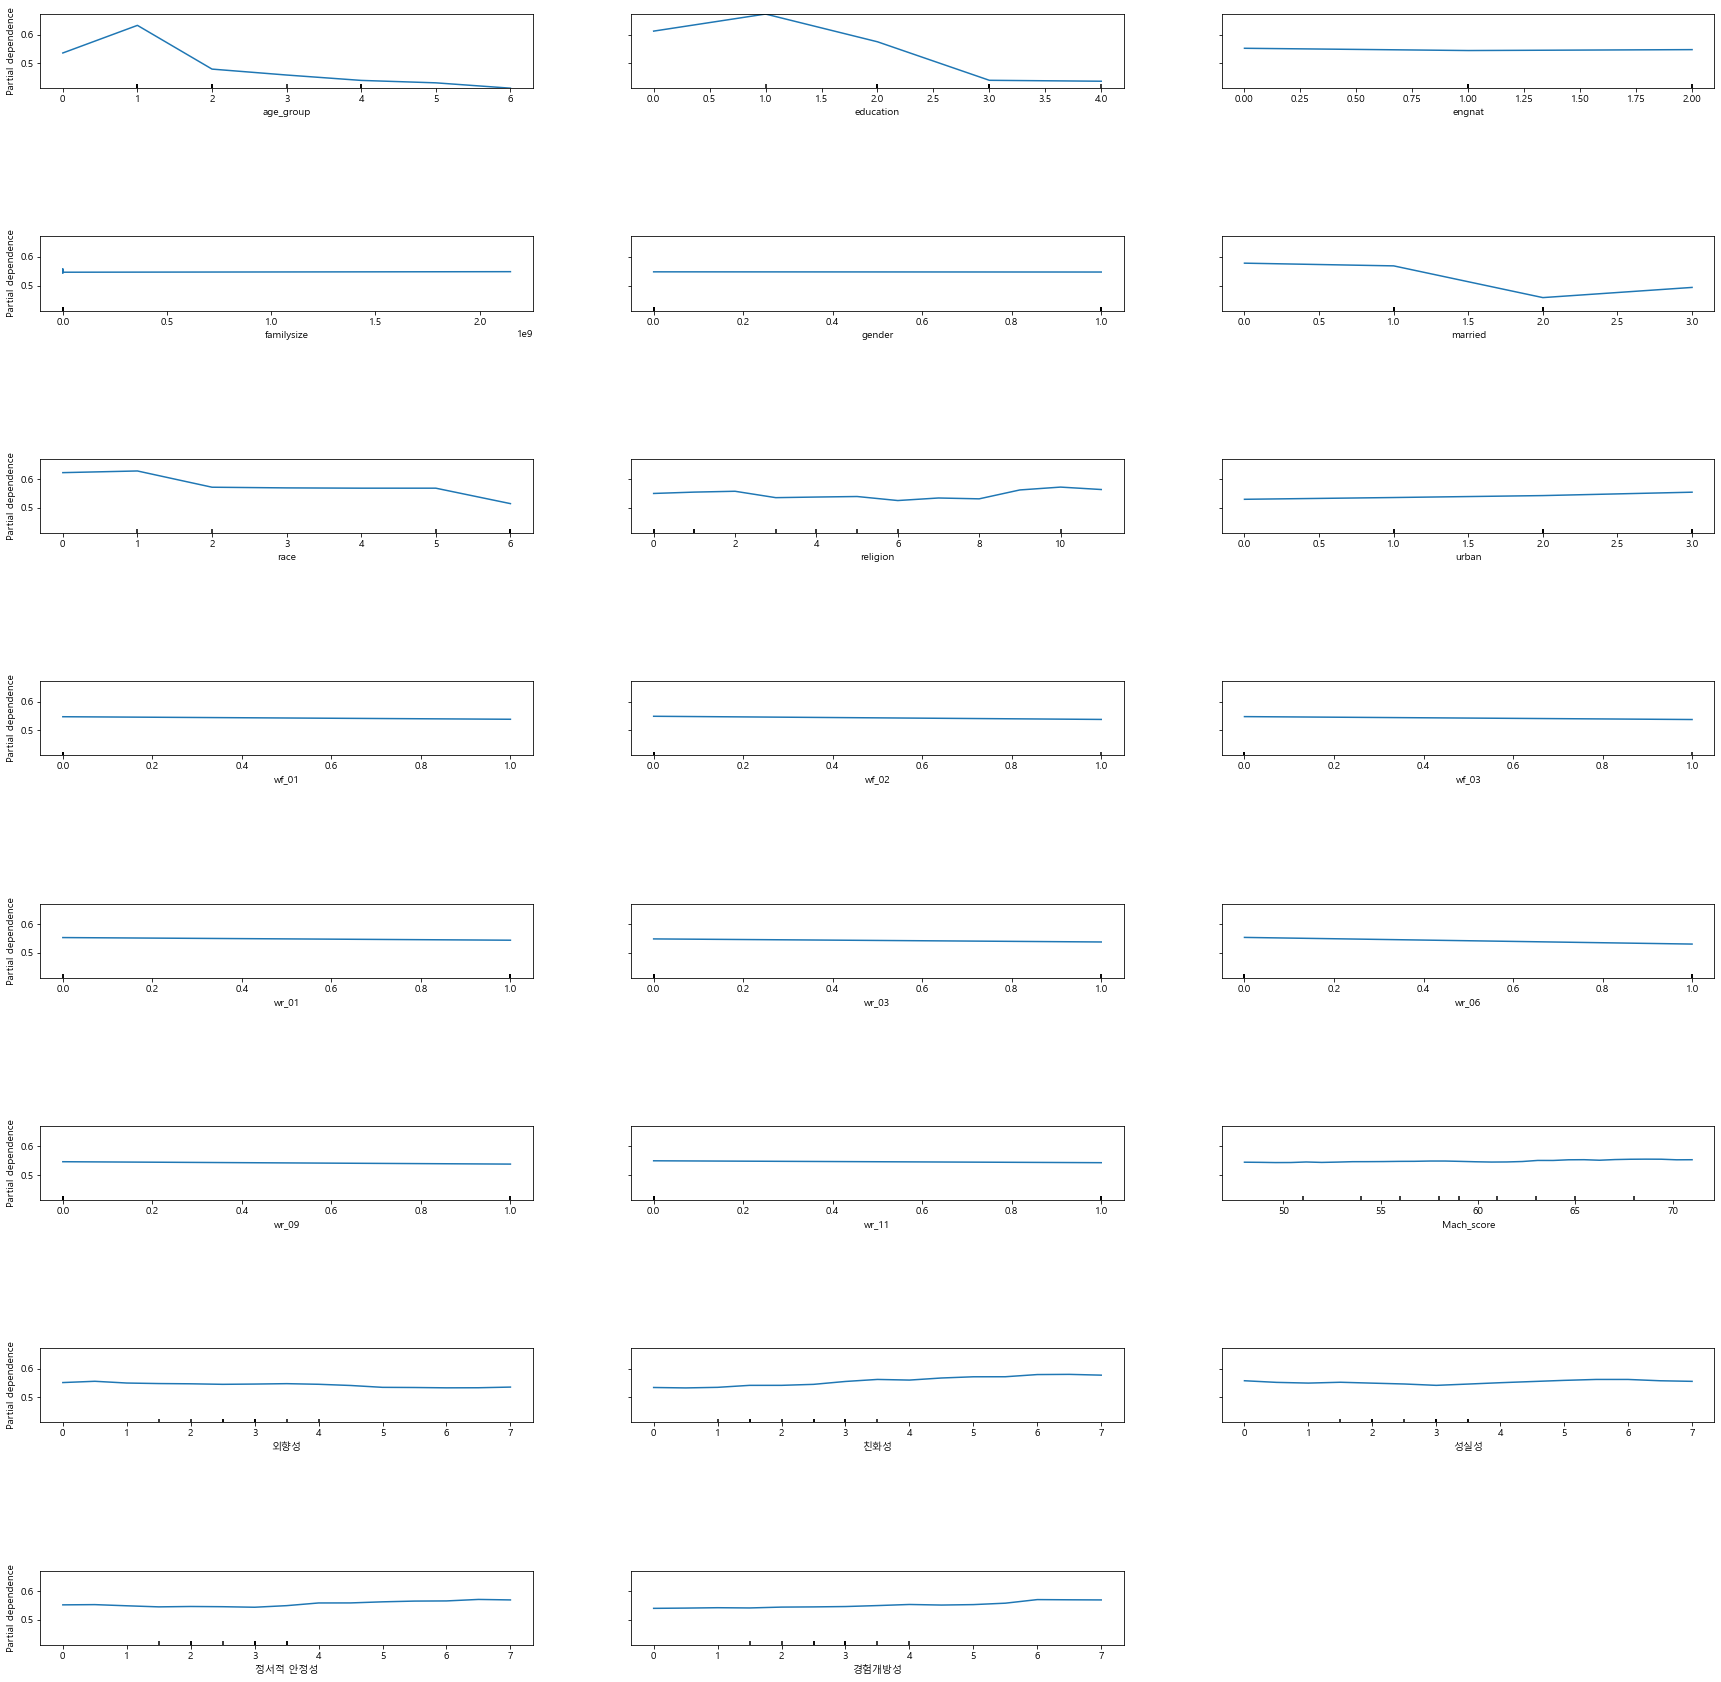

In [36]:
from sklearn.inspection import plot_partial_dependence
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
plt.rcParams['figure.figsize'] = (30,30)
features = x_train.columns
plot_partial_dependence(forest, x_train, features, n_jobs=3, grid_resolution=30)
fig = plt.gcf(); fig.subplots_adjust(hspace=2)

## 5. 상관관계 분석
### 1) age_group + Mach_score 상관관계
#### - 나이가 어릴수록 Mach_score가 높은 경향.

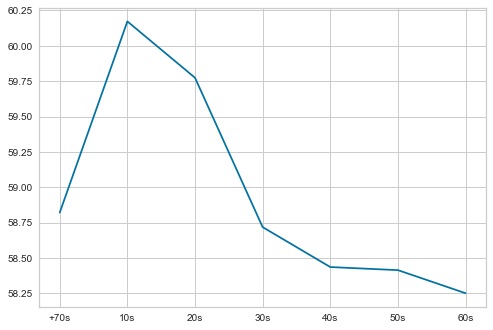

In [80]:
x12 = x_train.pivot_table('Mach_score', train['age_group'])
plt.plot(x12)

### 2) Mach_score와 voted 관계
#### - Mach_score가 높아질수록,투표율이 낮아지는 경향

<AxesSubplot:xlabel='Mach_score', ylabel='count'>

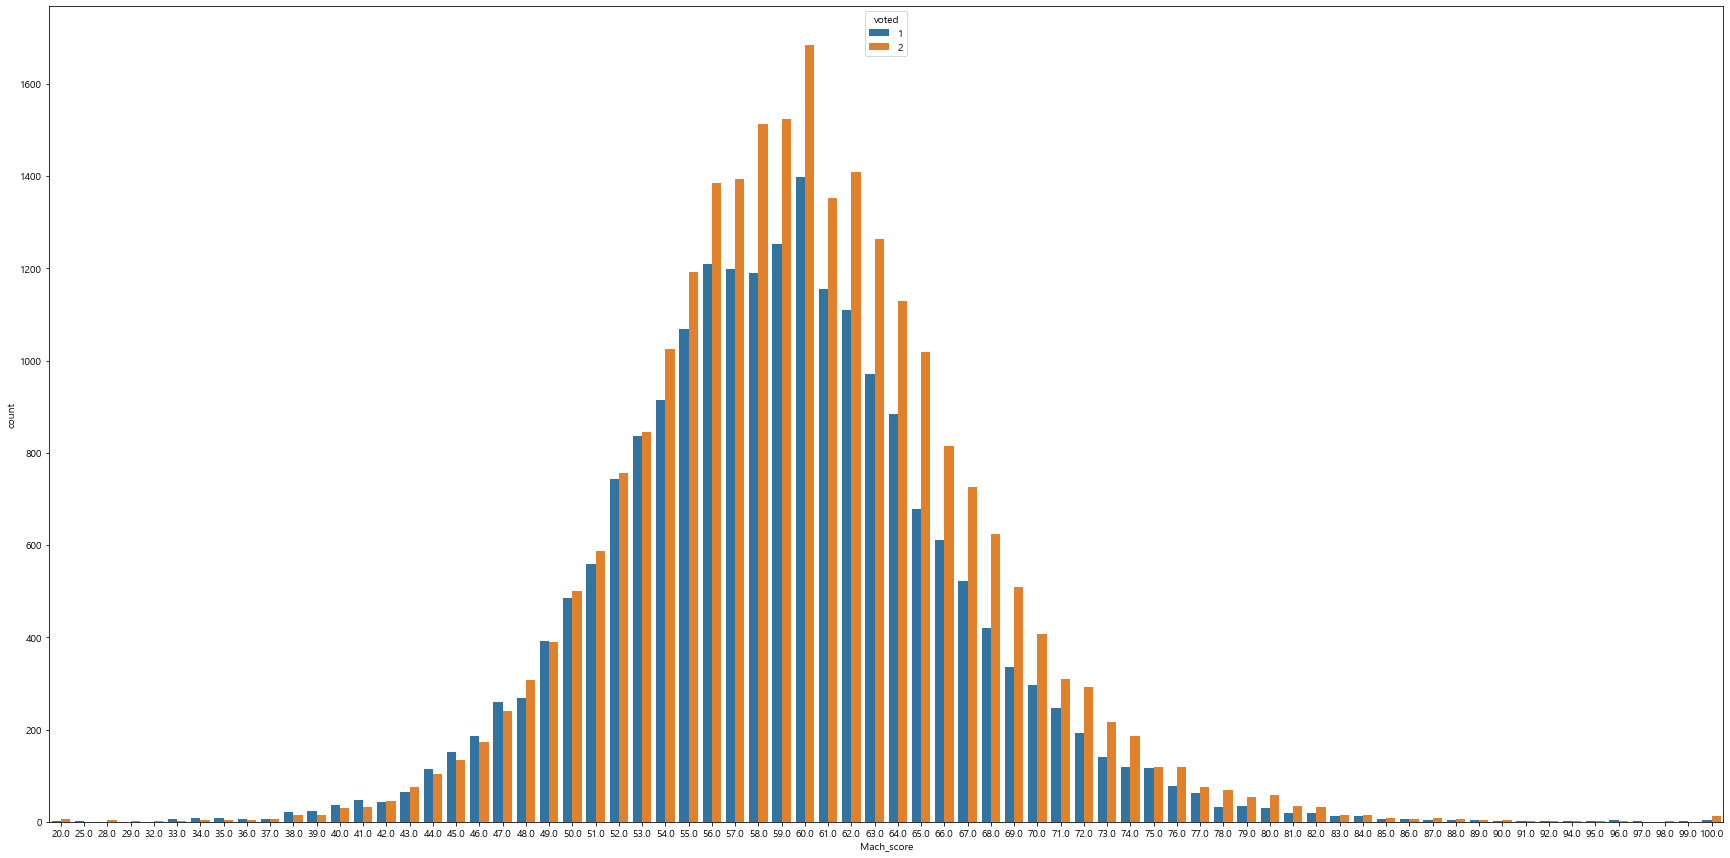

In [38]:
plt.figure(figsize = (30,15))
sns.countplot(data = df, x = 'Mach_score', hue = 'voted')

### 3) age_group + voted 상관관계

In [39]:
voted = eda_train[eda_train['voted']==1]
unvoted = eda_train[eda_train['voted']==2]

<AxesSubplot:xlabel='age_group', ylabel='count'>

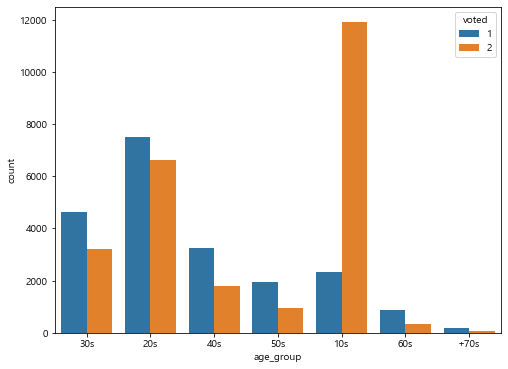

In [40]:
plt.figure(figsize = (8,6))
sns.countplot(data = eda_train, x = 'age_group', hue = eda_train['voted'])

### 4) gender + voted 상관관계

<AxesSubplot:xlabel='gender', ylabel='count'>

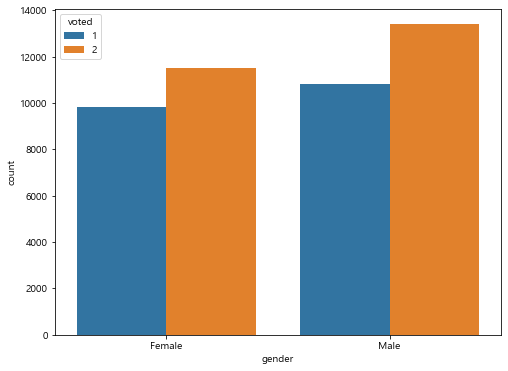

In [41]:
plt.figure(figsize = (8,6))
sns.countplot(data = eda_train, x = 'gender', hue = eda_train['voted'])

### 5) race + voted 상관관계

<AxesSubplot:xlabel='race', ylabel='count'>

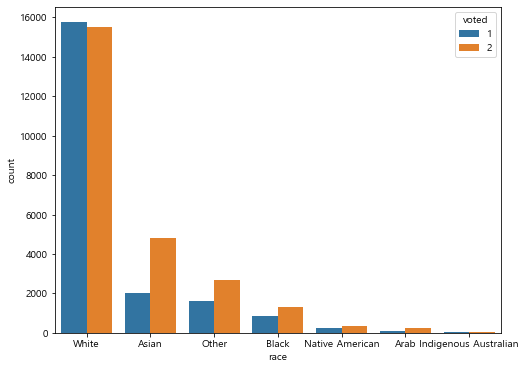

In [42]:
plt.figure(figsize = (8,6))
sns.countplot(data = eda_train, x = 'race', hue = eda_train['voted'])

### 6) 종교 + voted 상관관계

<AxesSubplot:xlabel='religion', ylabel='count'>

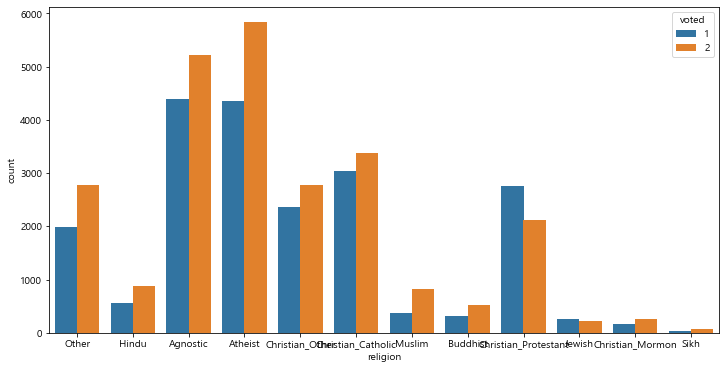

In [43]:
plt.figure(figsize = (12,6))
sns.countplot(data = eda_train, x = 'religion', hue = eda_train['voted'])

### 7) 유년시절 거주지역 + voted 상관관계

<AxesSubplot:xlabel='urban', ylabel='count'>

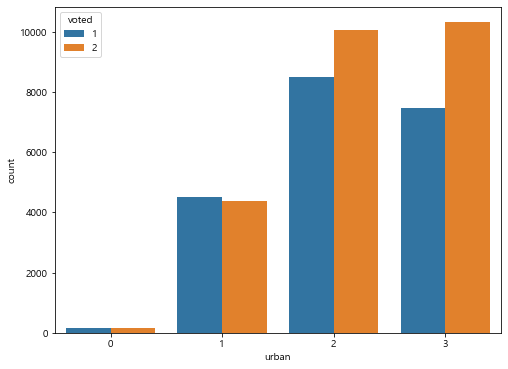

In [44]:
plt.figure(figsize = (8,6))
sns.countplot(data = eda_train, x = 'urban', hue = eda_train['voted'])

### 8) 모국어 영어 여부 + voted 상관관계

<AxesSubplot:xlabel='engnat', ylabel='count'>

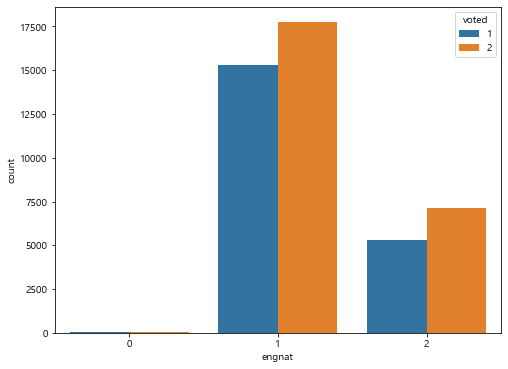

In [45]:
plt.figure(figsize = (8,6))
sns.countplot(data = eda_train, x = 'engnat', hue = eda_train['voted'])

### 9) 형제자매 수 + voted 상관관계

<AxesSubplot:xlabel='familysize', ylabel='count'>

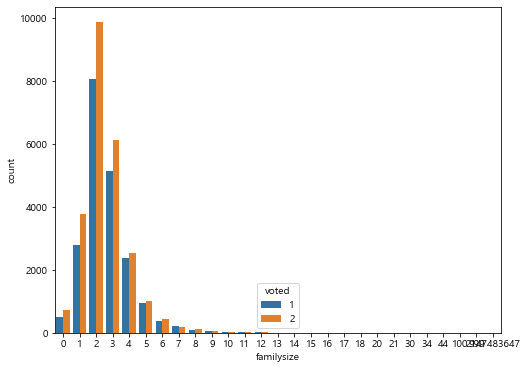

In [46]:
plt.figure(figsize = (8,6))
sns.countplot(data = eda_train, x = 'familysize', hue = eda_train['voted'])

## 5. Auto ML

### - test 5% Hold-out

In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(df, y_train, test_size=0.05, random_state=0)

### - 15개의 기본 모델을 학습하고 모델들의 성능을 비교& 분석

In [48]:
from pycaret.classification import*
clf = setup(data = df,
            target = 'voted', 
            ignore_low_variance = True,
            normalize = True,
            train_size = 0.95, # test 5% Hold-out
            session_id = 1357)

#ignore_low_variance : True로 설정하면 범주형 변수 중에 변수중요도가 낮은 변수를 삭제
#session_id : random_state와 같은 파라미터
#normalize : True로 설정하면 정규화
#group_features : 비슷한 특징을 가진 변수를 묶음

,Description,Value
0,session_id,1357
1,Target,voted
2,Target Type,Binary
3,Label Encoded,"1: 0, 2: 1"
4,Original Data,"(45532, 24)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,12
8,Ordinal Features,False
9,High Cardinality Features,False


### - AUC 기준 성능 상위 3개 모델 선발 

In [49]:
best_3 = compare_models(sort = 'AUC', n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6955,0.7668,0.6364,0.7667,0.6955,0.3962,0.4032,0.4050
catboost,CatBoost Classifier,0.6941,0.7662,0.6466,0.7580,0.6978,0.3921,0.3972,11.7120
gbc,Gradient Boosting Classifier,0.6943,0.7644,0.6361,0.7649,0.6946,0.3938,0.4005,2.6310
ada,Ada Boost Classifier,0.6908,0.7574,0.6466,0.7527,0.6956,0.3851,0.3897,0.8220
xgboost,Extreme Gradient Boosting,0.6881,0.7568,0.6532,0.7446,0.6959,0.3786,0.3820,2.3890
rf,Random Forest Classifier,0.6847,0.7529,0.6518,0.7401,0.6931,0.3717,0.3749,2.2400
lda,Linear Discriminant Analysis,0.6810,0.7510,0.6949,0.7138,0.7042,0.3582,0.3584,0.1920
lr,Logistic Regression,0.6811,0.7507,0.6977,0.7127,0.7050,0.3580,0.3581,1.5590
et,Extra Trees Classifier,0.6771,0.7448,0.6591,0.7250,0.6904,0.3546,0.3564,2.8670
nb,Naive Bayes,0.5664,0.7309,0.2379,0.9223,0.3609,0.1870,0.2928,0.0560


### - Score 최적화를 위해 soft vote ensemble 사용

In [50]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6949,0.7676,0.6375,0.7649,0.6954,0.3949,0.4015
1,0.7049,0.7718,0.6392,0.7808,0.7030,0.4155,0.4237
2,0.7020,0.7721,0.6404,0.7752,0.7013,0.4093,0.4168
3,0.6894,0.7601,0.6361,0.7567,0.6912,0.3835,0.3893
4,0.6965,0.7669,0.6463,0.7620,0.6994,0.3970,0.4025
Mean,0.6975,0.7677,0.6399,0.7679,0.6981,0.4000,0.4068
SD,0.0054,0.0044,0.0035,0.0088,0.0043,0.0113,0.0122


### - Train dataset을 통해 예측률 확인 (예측성공률 AUC : 0.7651)

In [51]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6996,0.7651,0.6553,0.7697,0.7079,0.4028,0.4083


### - 모델 튜닝으로 성능향상 (AUC : 0.7651 -> 0.7666)

In [52]:
tunes_model = tune_model(blended, fold = 3)
tunes_model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6996,0.7679,0.6358,0.7741,0.6982,0.4049,0.4127
1,0.6985,0.7685,0.6426,0.7677,0.6996,0.4017,0.4081
2,0.6945,0.7632,0.6446,0.7598,0.6975,0.3931,0.3985
Mean,0.6975,0.7666,0.6410,0.7672,0.6984,0.3999,0.4065
SD,0.0022,0.0023,0.0038,0.0058,0.0009,0.0050,0.0059


VotingClassifier(estimators=[('lightgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=1357, reg_alpha=0.0,
                                             reg_lambda=0.0, silent=True,
                                             s...
                                                         m

### - final_model 최종 예측성공률 (AUC : 0.7666 - > 0.8098)

In [53]:
final_model = finalize_model(tunes_model)

In [54]:
pred_holdout = predict_model(final_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7347,0.8098,0.6870,0.8069,0.7421,0.4726,0.4791


### - Test dataset을 통한 최종 Score 추출

In [55]:
predictions = predict_model(final_model, data = X_test)

In [56]:
predictions

,age_group,education,engnat,familysize,gender,married,race,religion,urban,wf_01,...,wr_11,Mach_score,외향성,친화성,성실성,정서적 안정성,경험개방성,voted,Label,Score
21964,1,2,2,2,0,1,5,0,3,0,...,1,76.0,5.0,0.5,1.5,3.0,2.5,2,2,0.8815
19947,2,4,2,1,0,1,2,7,3,0,...,0,55.0,3.0,1.0,3.0,2.0,3.0,2,2,0.5127
15906,2,3,2,7,1,1,1,0,3,0,...,0,74.0,0.0,0.0,0.0,1.5,1.5,2,2,0.6753
37973,3,4,2,1,1,2,1,0,3,0,...,0,68.0,2.0,2.0,3.0,3.0,2.5,2,2,0.6385
25088,2,4,2,2,0,1,1,1,3,1,...,1,54.0,2.0,3.0,3.0,1.0,3.0,2,2,0.6631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9621,2,2,1,4,0,1,6,3,2,0,...,0,51.0,3.5,1.0,1.5,3.5,2.5,1,1,0.5122
31418,2,3,2,2,0,1,6,0,3,0,...,0,60.0,2.5,1.5,2.5,3.5,3.0,1,1,0.6183
4701,2,3,1,3,0,2,4,1,3,0,...,1,56.0,3.5,2.0,3.0,2.0,2.5,1,1,0.6394
18347,1,2,1,5,0,1,0,3,3,0,...,0,56.0,3.5,1.0,5.5,1.0,3.0,2,2,0.9048


### voted (타겟): 지난 해 국가 선거 투표 여부 (1 = Yes, 2 = No) -> (0 = yes, 1 = No)

In [57]:
predictions.Label = predictions.Label -1 

### - Label : Voted ,      투표 여부 (0 = yes, 1 = No)
### - Score : 예측점수 , 투표 여부 (0 = yes, 1 = No)

In [58]:
predictions

,age_group,education,engnat,familysize,gender,married,race,religion,urban,wf_01,...,wr_11,Mach_score,외향성,친화성,성실성,정서적 안정성,경험개방성,voted,Label,Score
21964,1,2,2,2,0,1,5,0,3,0,...,1,76.0,5.0,0.5,1.5,3.0,2.5,2,1,0.8815
19947,2,4,2,1,0,1,2,7,3,0,...,0,55.0,3.0,1.0,3.0,2.0,3.0,2,1,0.5127
15906,2,3,2,7,1,1,1,0,3,0,...,0,74.0,0.0,0.0,0.0,1.5,1.5,2,1,0.6753
37973,3,4,2,1,1,2,1,0,3,0,...,0,68.0,2.0,2.0,3.0,3.0,2.5,2,1,0.6385
25088,2,4,2,2,0,1,1,1,3,1,...,1,54.0,2.0,3.0,3.0,1.0,3.0,2,1,0.6631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9621,2,2,1,4,0,1,6,3,2,0,...,0,51.0,3.5,1.0,1.5,3.5,2.5,1,0,0.5122
31418,2,3,2,2,0,1,6,0,3,0,...,0,60.0,2.5,1.5,2.5,3.5,3.0,1,0,0.6183
4701,2,3,1,3,0,2,4,1,3,0,...,1,56.0,3.5,2.0,3.0,2.0,2.5,1,0,0.6394
18347,1,2,1,5,0,1,0,3,3,0,...,0,56.0,3.5,1.0,5.5,1.0,3.0,2,1,0.9048


### ML모델 평가

In [61]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

<Figure size 576x396 with 0 Axes>

## Confusion Matrix
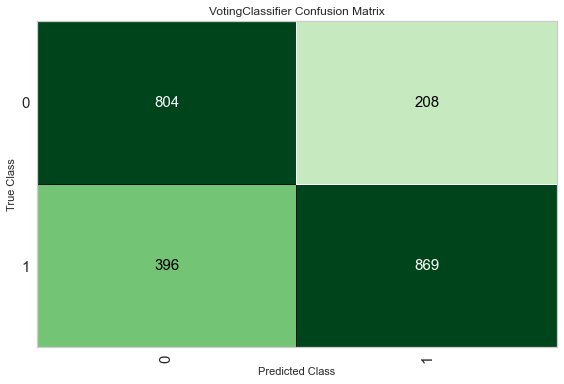

## 보정 곡선(Calibration plot)
### 모델의 예측값을 기준으로 10분위 구간 (0%, 10%, 20%, … 90, 100%)의 구간으로 예측 확률과 실제 비율의 관계
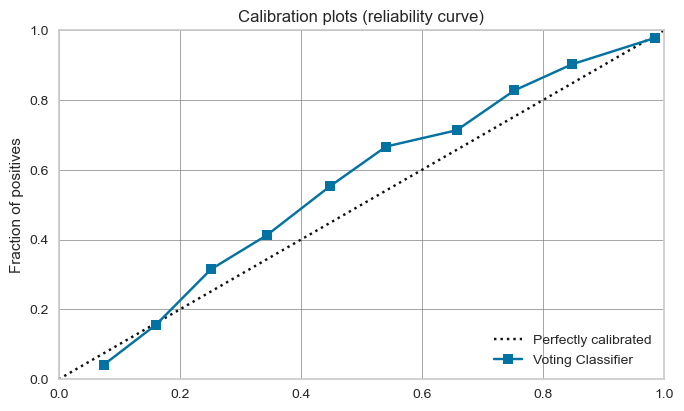